# <center><h2><b>Q_impact project</b></h2></center>

**We're trying to find correct constants in Q prescription**

\begin{equation}
      q = - \frac{\alpha_C }{ Z} \frac{Z + 0.24}{Z + 4.2} T^{\alpha_N} \frac{dT}{dx}
\end{equation}

**Importing needed packages**

In [122]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import CubicSpline
import math
import sys
%matplotlib ipympl
#!!!
def impdata(filename):
    url=f'https://raw.githubusercontent.com/homijan/ML-student-projects/intro-ab/students/bogdaale/gd-profiles/{filename}'
    return url
#!!!


**Importing data**

In [123]:
x_Te, Te = np.loadtxt(impdata('Te_gdhohlraum_cm_10ps_TekeV_interp.txt'), usecols=(0, 1), unpack=True)
x_ne, ne = np.loadtxt(impdata('ne_gdhohlraum_cm_ne1e20cm3_interp.txt'), usecols=(0, 1), unpack=True)
x_Zbar, Zbar = np.loadtxt(impdata('Zbar_gdhohlraum_cm_Z_interp.txt'), usecols=(0, 1), unpack=True)

x_Qloc, Qloc = np.loadtxt(impdata('Q_gdhohlraum_microns_10ps_LocalWcm2.txt'), usecols=(0, 1), unpack=True)
x_Qimpact, Qimpact = np.loadtxt(impdata('Q_gdhohlraum_microns_10ps_IMPACTWcm2.txt'), usecols=(0, 1), unpack=True)
x_Qsnb, Qsnb = np.loadtxt(impdata('Q_gdhohlraum_microns_10ps_separatedsnbWcm2.txt'), usecols=(0, 1), unpack=True)

x_Qc7bBGK, Qc7bBGK, Knx = np.loadtxt(impdata('Q_gdhohlraum_cm_10ps_c7b-bgk-Wcm2-clogCHIC.txt'), comments='#',\
                                     delimiter=',', usecols=(0, 8, 6), unpack=True)
x_Qc7bAWBS, Qc7bAWBS = np.loadtxt(impdata('Q_gdhohlraum_cm_10ps_c7b-awbs-Wcm2-clogCHIC.txt'), comments='#',\
                                  delimiter=',', usecols=(0, 8), unpack=True)

# changing units um->cm
x_Qloc/=1e4
x_Qimpact/=1e4
x_Qsnb/=1e4


**This block allows to control the fitting script via command line**

In [124]:
# Use alphaN
useC = True
useX = False
useN = False
useXN = False
useX2 = False
useXN1 = False

print('Choose the option of fitting \n 1 - fitting with constant argument alphaC \n 2 - fitting with monomic alphaC \n 3 - constant alphaN')
print(' 4 - monomic alphaN \n 5 - strange \n 6 - even stranger')

fitoption=input()
if fitoption=='': fitoption = '1' 

# Transform data to match given spatial interval 
# Default values spanning the whole c7b spatial domain

if (fitoption == '1'):
    useC = True; useX = False; useN = False; useXN = False; useX2 = False; useXN1 = False
else:
    if (fitoption == '2'):
        useC = False; useX = True; useN = False; useXN = False; useX2 = False; useXN1 = False
    else:
        if (fitoption == '3'):
            useC = False; useX = False; useN = True; useXN = False; useX2 = False; useXN1 = False
        else:
            if (fitoption == '4'):
                useC = False; useX = False; useN = False; useXN = True; useX2 = False; useXN1 = False
            else:
                if (fitoption == '5'):
                    useC = False; useX = False; useN = False; useXN = False; useX2 = True; useXN1 = False
                else:
                    if (fitoption == '6'):
                        useC = False; useX = False; useN = False; useXN = False; useX2 = False; useXN1 = True
                    else:
                        print(f'Unknown option {fitoption}'); quit();


Choose the option of fitting 
 1 - fitting with constant argument alphaC 
 2 - fitting with monomic alphaC 
 3 - constant alphaN
 4 - monomic alphaN 
 5 - strange 
 6 - even stranger



In [125]:
print('set starting point of fit')
xmin=input()
if xmin=='': xmin = -1.0
else: xmin=float(xmin)
print('set ending point of fit')
xmax=input()
if xmax=='': xmax = 1.0
else: xmax=float(xmax)

set starting point of fit

set ending point of fit



**Here the cubic spline interpolation is implemented**
Interpolation is needed due to the non-simultaneous collecting data from different sensors **???**

In [126]:
xmax
#xmin = -1.0; xmax = 1.0

1.0

In [127]:
def getsub(f, x, xref):
    f_cs = CubicSpline(x, f)
    return f_cs(xref)


xref = x_Te[np.logical_and(x_Te > xmin, x_Te < xmax)]
Te = getsub(Te, x_Te, xref)
ne = getsub(ne, x_ne, xref)
Zbar = getsub(Zbar, x_Zbar, xref)
Qloc = getsub(Qloc, x_Qloc, xref)
Qimpact = getsub(Qimpact, x_Qimpact, xref)
Qsnb = getsub(Qsnb, x_Qsnb, xref)
Qc7bBGK = getsub(Qc7bBGK, x_Qc7bBGK, xref)
Knx = getsub(Knx, x_Qc7bBGK, xref)
Qc7bAWBS = getsub(Qc7bAWBS, x_Qc7bAWBS, xref)
#calculating Te gradient
gradTe=np.gradient(Te, xref)

#!!! 3-th task
def fitQloc(X, k):
    #fit function for Qloc profile
    Z, T, gradT = X
    q = -(k/Z)*((Z+0.24)/(Z+4.2))*T**2.5*gradT
    return q
par3, cov3 = curve_fit(fitQloc, (Zbar, Te, gradTe), Qloc,  maxfev = 1000)
standev3=np.sqrt(np.diag(cov3))
kQSH = par3[0]
print(f'Constant from Qloc profile k = {par3[0]:.1e} ± {standev3[0]:.1e}')


Constant from Qloc profile k = 6.1e+02 ± 3.4e-02


#### 4th task 

In [128]:
def fitQimpact(X, alpha0, alpha1, alpha2, alpha3, alpha4):
    #fit function for Qloc profile
    x, Z, T, gradT = X
    if (useC):
        q = -(alpha0 * kQSH / Z) * ((Z + 0.24) / (Z + 4.2)) * T**2.5 * gradT 
    else:
        if (useX):
            q = ( -((alpha0 + alpha1 * x) * kQSH / Z) * ((Z + 0.24)/(Z+4.2)) *T**2.5 * gradT )
        else:
            if (useN):
                q = ( -(alpha0 * kQSH / Z) * ((Z + 0.24) / (Z + 4.2)) *T**(2.5 * 1.0 / (1.0 + np.exp(alpha3))) * gradT )
            else: 
                if (useXN):
                    q = ( -((alpha0 + alpha1 * x) * kQSH / Z) * ((Z + 0.24) / (Z + 4.2))* T**(2.5 * 1.0 / (1.0 + np.exp(alpha3))) * gradT )
                else: 
                    if (useX2):
                        q = ( -((alpha0 + alpha1 * x + alpha2 * x * x) * kQSH / Z) *((Z + 0.24) / (Z + 4.2)) * T**2.5 * gradT )
                    else:
                        if (useXN1):
                            q = ( -((alpha0 + alpha1 * x) * kQSH / Z) * ((Z + 0.24) / (Z + 4.2)) *\
                                 T**(2.5 * 1.0 / (1.0 + np.exp(alpha3 + alpha4 * x))) * gradT )
                        else:
                            print("Unknown loss function")
    return q

In [129]:


#!!! 5-th task
N = 3
if (len(sys.argv) > 4):
  N = int(sys.argv[4])

print("     For N = ", N, '\n')
# split the data we use in fit
split_Z = np.array_split(Zbar, N)
split_T = np.array_split(Te, N)
split_gradT = np.array_split(gradTe, N)
split_Qimpact = np.array_split(Qimpact, N)    #split the data we want to fit
split_x = np.array_split(xref, N)             #split the x axes to know at which subinterval we currently are
subfits = np.array([[],[]])                   #contain fit data for each subinterval
for sub, _ in enumerate(split_x):             #fitting for each subinterval of xref
    pars, covs = curve_fit(fitQimpact, (split_x[sub], split_Z[sub],split_T[sub], split_gradT[sub]), split_Qimpact[sub],  maxfev = 100000)
    standevs = np.sqrt(np.diag(covs))
    print(f'Pars in subinterval x in <{split_x[sub][0]:.3e} ; {split_x[sub][-1]:.3e}>:','\n',\
        f'alpha0 = {pars[0]:.2e} ± {standevs[0]:.2e}','\n',\
        f'alpha1 = {pars[1]:.2e} ± {standevs[1]:.2e}','\n',\
        f'alpha2 = {pars[1]:.2e} ± {standevs[1]:.2e}','\n',\
        f'alpha3 = {pars[1]:.2e} ± {standevs[1]:.2e}','\n',\
        f'alpha4 = {pars[1]:.2e} ± {standevs[1]:.2e}','\n')
    qsub = fitQimpact((split_x[sub], split_Z[sub], split_T[sub],split_gradT[sub]), *pars)
    subfits = np.concatenate((subfits, np.array([split_x[sub],qsub])), axis = 1)
    


     For N =  3 

Pars in subinterval x in <1.169e-03 ; 6.350e-02>: 
 alpha0 = 5.23e-01 ± inf 
 alpha1 = 1.00e+00 ± inf 
 alpha2 = 1.00e+00 ± inf 
 alpha3 = 1.00e+00 ± inf 
 alpha4 = 1.00e+00 ± inf 

Pars in subinterval x in <6.351e-02 ; 1.258e-01>: 
 alpha0 = 4.89e-01 ± inf 
 alpha1 = 1.00e+00 ± inf 
 alpha2 = 1.00e+00 ± inf 
 alpha3 = 1.00e+00 ± inf 
 alpha4 = 1.00e+00 ± inf 

Pars in subinterval x in <1.258e-01 ; 1.882e-01>: 
 alpha0 = 1.00e-01 ± inf 
 alpha1 = 1.00e+00 ± inf 
 alpha2 = 1.00e+00 ± inf 
 alpha3 = 1.00e+00 ± inf 
 alpha4 = 1.00e+00 ± inf 



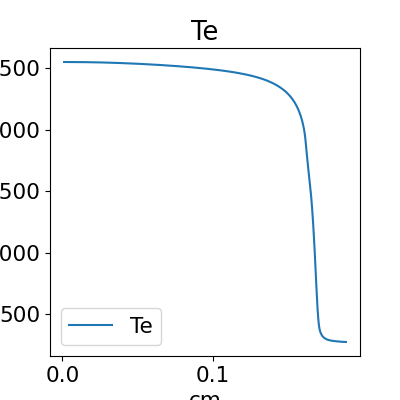

In [130]:
#plot stuff
fontsize = 15.5
figuresize=4
plt.rcParams.update({'font.size': fontsize})

fig1, axs1 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs1.plot(xref, Te, label="Te")
axs1.set_xlabel('cm')
axs1.set_ylabel('eV')
axs1.set_title('Te')
#axs1.autoscale(enable=True, axis='x', tight=True)
axs1.legend()

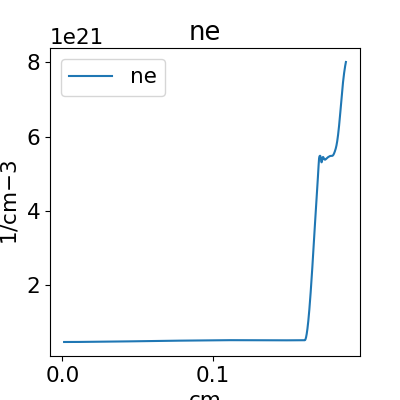

In [131]:
fig2, axs2 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs2.plot(xref, ne, label="ne")
axs2.set_xlabel('cm')
axs2.set_ylabel('1/cm$-3$')
axs2.set_title('ne')
#axs2.autoscale(enable=True, axis='x', tight=True)
axs2.legend()



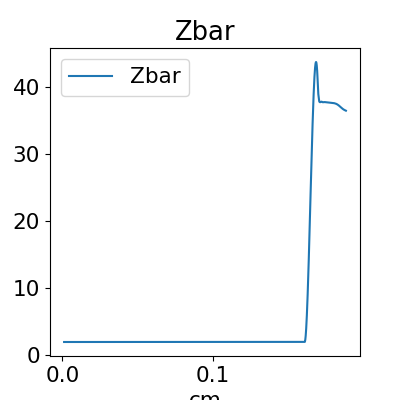

In [132]:
fig3, axs3 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs3.plot(xref, Zbar, label="Zbar")
axs3.set_xlabel('cm')
axs3.set_title('Zbar')
#axs3.autoscale(enable=True, axis='x', tight=True)
axs3.legend()


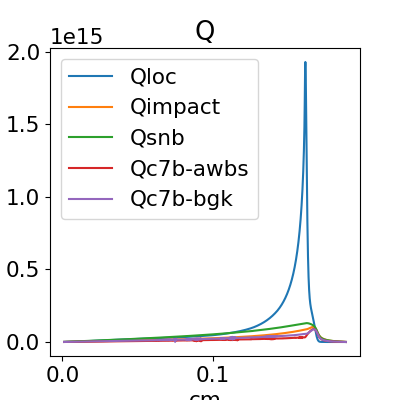

In [133]:

fig4, axs4 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs4.plot(xref, Qloc, label="Qloc")
axs4.plot(xref, Qimpact, label="Qimpact")
axs4.plot(xref, Qsnb, label="Qsnb")
#axs4.plot(xref, Qc7bAWBS, label="Qc7b-awbs")
axs4.plot(xref, gaussian_filter1d(Qc7bAWBS,3), label="Qc7b-awbs")
#axs4.plot(xref, Qc7bBGK, label="Qc7b-bgk")
axs4.plot(xref, gaussian_filter1d(Qc7bBGK, 3), label="Qc7b-bgk")
axs4.set_xlabel('cm')
axs4.set_ylabel('W/cm$^2$')
axs4.set_title('Q')
#axs4.autoscale(enable=True, axis='x', tight=True)
axs4.legend(loc='upper left')



Text(0.5, 1.0, 'Knudsen number $Kn_{\\mathrm{x}}$')

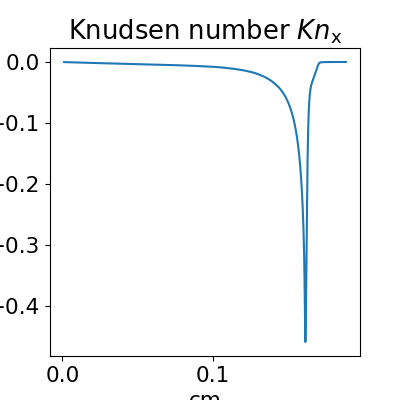

In [134]:
fig5, axs5 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs5.plot(xref, Knx)
axs5.set_xlabel('cm')
axs5.set_ylabel('[-]')
axs5.set_title(label=r"Knudsen number $Kn_{\mathrm{x}}$")



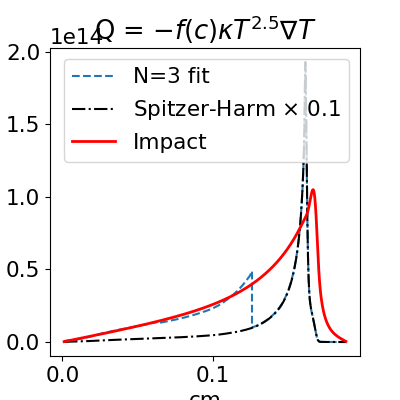

In [135]:
fig6, axs6 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs6.plot(subfits[0,:],subfits[1,:], '--', label = f'N={N} fit')
axs6.plot(xref, Qloc/1e1, 'k-.', label = r'Spitzer-Harm $\times$ 0.1')
axs6.plot(xref, Qimpact, 'r', label="Impact", linewidth=2.0)
axs6.set_xlabel('cm')
axs6.set_ylabel('W/cm$^2$')
axs6.legend()
if (useC):
    axs6.set_title(r'Q = $- f(c) \kappa T^{2.5} \nabla T$')
else:
    if (useX):
        axs6.set_title(r'Q = $- f(c+ax) \kappa T^{2.5} \nabla T$')
    else:
        if (useN):
            axs6.set_title(r'Q = $- f(c) \kappa T^{\alpha(c)} \nabla T$')
        else:
            if (useXN):
                axs6.set_title(r'Q = $- f(c+ax) \kappa T^{\alpha(c)} \nabla T$')
            else:
                if (useX2):
                    axs6.set_title(r'Q = $- f(c+ax+bx^2) \kappa T^{2.5} \nabla T$')
                else:
                    if (useXN1):
                        axs6.set_title(r'Q = $- f(c+ax) \kappa T^{\alpha(c+ax)} \nabla T$')
                    else:
                        print("Unknown title option."); quit()
plt.show()